# How common is introduced unfairness

In the paper

*Why fair lables can yield unfair predictions: graphical conditions on introduced unfairness*  
Carolyn Ashurst, Ryan Carey, Silvia Chiappa, Tom Everitt  
AAAI, 2022


we explore conditions under which fair labels can yield optimal unfair models. This notebook illustrates how PyCID can be used to investigate this question, by defining methods for graphical criteria and randomly sampling supervised learning CIDs.

To open and run this notebook in your browser with Google Colab, use this link:  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/causalincentives/pycid/blob/master/notebooks/Why_fair_labels_may_yield_unfair_models_AAAI_22.ipynb)

In [1]:
# @title Imports

#importing necessary libraries
try:
    import pycid
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid
    import pycid
    
import numpy as np
import networkx as nx
import random

## Definitions

Define ITV and methods for checking the graphical conditions

In [2]:
def decision(cid):
  return list(cid.decisions)[0]

def total_variation(cid: pycid.CID, a: str, x: str) -> float:
    """the total variation on x from varying a"""
    return cid.expected_value([x], {a: 1})[0] - cid.expected_value([x], {a: 0})[0]

def introduced_total_variation(cid: pycid.CID, a: str, d: str, y: str) -> float:
    """The total introduced variation, comparing the effect of a on d and y"""
    return np.abs(total_variation(cid, a, d)) - np.abs(total_variation(cid, a, y))
  
def theorem9_gc(cid: pycid.CID) -> bool:
  """ITV is possible under arbitrary loss"""
  for x in cid.get_parents(list(cid.decisions)[0]):
    condition = [list(cid.decisions)[0]] + cid.get_parents(list(cid.decisions)[0])
    condition.remove(x)
    if cid.is_active_trail('A', x, []) and cid.is_active_trail(x, 'U', condition):
      return True
  return False

def theorem11_gc(cid: pycid.CID) -> bool:
  """ITV is possible under P-admissible loss"""
  return theorem9_gc(cid) and not 'A' in cid.get_parents(list(cid.decisions)[0]) and cid.is_active_trail('A', 'U', [list(cid.decisions)[0]] + cid.get_parents(list(cid.decisions)[0]))

In [3]:
def assess_unfairness(cid):
  cid_copy = cid.copy() # make a copy to avoid making unwanted changes
  print("ITV under 0-1 loss possible: ", theorem9_gc(cid_copy))
  print("ITV under P-adm loss possible: ", theorem11_gc(cid_copy))

  # impute an optimal policy under the specified 0-1 loss, and compute actual ITV
  cid_copy.impute_optimal_policy()
  print("actual ITV under 0-1 loss", introduced_total_variation(cid_copy, 'A', list(cid.decisions)[0], 'Y'))

  # the optimal policy under P-admissible loss is the conditional expectation.
  # We impute that policy instead, and recompute ITV
  cid_copy.impute_conditional_expectation_decision(list(cid.decisions)[0], 'Y')
  print("actual ITV under P-adm loss", introduced_total_variation(cid_copy, 'A', list(cid.decisions)[0], 'Y'))

## Examples

### Hiring example

True


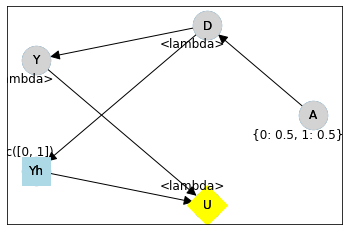

ITV under 0-1 loss possible:  True
ITV under P-adm loss possible:  False
actual ITV under 0-1 loss 0.5880000000000001
actual ITV under P-adm loss 0.0


In [4]:
hiring = pycid.CID(
    [('A', 'D'),
     ('D', 'Y'),
     ('D', 'Yh'),
     ('Y', 'U'),
     ('Yh', 'U')],
      decisions = ['Yh'],
      utilities = ['U']
    )

hiring.add_cpds(
    A = pycid.bernoulli(0.5),
    D = lambda a: pycid.noisy_copy(a, 0.8),
    Y = lambda d: pycid.bernoulli(0.49 + 0.02*d),
    U = lambda y, yh: int(y==yh),
    Yh = [0, 1],
)
print(hiring.check_model())
hiring.draw()
assess_unfairness(hiring)

## Music Example

First consider the version where A is not a feature. There is ITV under either loss function.

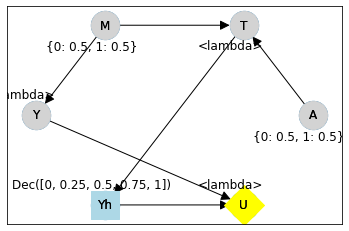

ITV under 0-1 loss possible:  True
ITV under P-adm loss possible:  True
actual ITV under 0-1 loss 0.04999999999999993
actual ITV under P-adm loss 0.04049999999999998


In [5]:
music_cid = pycid.CID(
      [('A', 'T'),
      ('M', 'T'),
      ('M', 'Y'),
      ('T', 'Yh'),
      ('Yh', 'U'),
      ('Y', 'U')],
      decisions = ['Yh'],
      utilities = ['U']
    )
music_cid.add_cpds(
      A = pycid.bernoulli(0.5),
      M = pycid.bernoulli(0.5),
      T = lambda a, m: {0: None,  # this becomes 1-P(T=1)
                        1: (0.05 if m==0 else 
                            0.9  if m==1 and a==1 else
                            1)},
      Y = lambda m: pycid.noisy_copy(m, 0.95),
      U = lambda y, yh: -(yh-y)**2,
      Yh = [0, 0.25, 0.5, 0.75, 1]
  )
music_cid.draw()
assess_unfairness(music_cid)

Next, lets make A a feature by adding an arrow A -> Yh

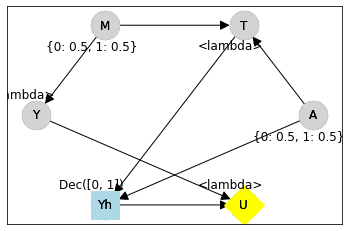

ITV under 0-1 loss possible:  True
ITV under P-adm loss possible:  False
actual ITV under 0-1 loss 0.050000000000000044
actual ITV under P-adm loss 0.0


In [6]:
music_a_feature = pycid.CID(
      [('A', 'T'),
      ('M', 'T'),
      ('M', 'Y'),
      ('T', 'Yh'),
      ('Yh', 'U'),
      ('Y', 'U'),
      ('A', 'Yh'),  # now A is a feature
      ],
      decisions = ['Yh'],
      utilities = ['U']
    )
music_a_feature.add_cpds(
      A = pycid.bernoulli(0.5),
      M = pycid.bernoulli(0.5),
      T = lambda a, m: {0: None,  # this becomes 1-P(T=1)
                        1: (0.05 if m==0 else 
                            0.9  if m==1 and a==1 else
                            1)},
      Y = lambda m: pycid.noisy_copy(m, 0.95),
      U = lambda y, yh: int(y == yh),
      Yh = [0, 1]
  )
music_a_feature.draw()
assess_unfairness(music_a_feature)

A predictor optimizing P-admissible loss now has ITV=0.

However, as we discuss in the paper, one caveat to this result is that women who passed the test are actually slightly disfavoured compared to men who pass the test. Meanwhile, women who fail the test benefit:

In [7]:
music_a_feature.impute_conditional_expectation_decision('Yh', 'Y')
print('chance of getting accepted given passed test: ', "{:.3f}".format(music_a_feature.expected_value(['Yh'], {'T': 1})[0]))
print('chance of getting accepted for men who passed the test', "{:.3f}".format(music_a_feature.expected_value(['Yh'], {'T': 1, 'A': 0})[0]))
print('chance of getting accepted for women who passed the test', "{:.3f}".format(music_a_feature.expected_value(['Yh'], {'T': 1, 'A': 1})[0]))
print()
print('chance of getting accepted for men who failed the test', "{:.2f}".format(music_a_feature.expected_value(['Yh'], {'T': 0, 'A': 0})[0]))
print('chance of getting accepted for women who failed the test', "{:.2f}".format(music_a_feature.expected_value(['Yh'], {'T': 0, 'A': 1})[0]))

chance of getting accepted given passed test:  0.905
chance of getting accepted for men who passed the test 0.907
chance of getting accepted for women who passed the test 0.903

chance of getting accepted for men who failed the test 0.05
chance of getting accepted for women who failed the test 0.14


## Generate random supervised learning CIDs

Here we create a method to generate a random supervised learning CID, with 'special' nodes D, Y, U, and A. The only parents of U are D and Y, and D only has a single child U.

In [8]:
def random_supervised_learning_cid(number_of_nodes: int = 6, 
                                   edge_density: float = 0.4) -> pycid.CID:
    """
    Generates a CID with 'special' nodes D, Y, U, and A to model a supervised
    learning setup. 
    The only parents of U are D and Y, and D only has a single child U.
    
    The graph is always connected. The edge_density parameter specifies how many
    edges are added additionally.
    
    Parameters:
    -----------
    number_of_nodes: how many nodes in the graph
    edge_density: how densely connected is the graph, between 0 and 1
    """
    dag = pycid.random_dag(number_of_nodes=number_of_nodes-1, edge_density=edge_density)
    remaning_nodes = list(nx.topological_sort(dag))
    # choose a decision node
    decision_node = remaning_nodes.pop()
    # choose a label node
    y_node = random.choice(remaning_nodes)
    remaning_nodes.remove(y_node)
    # choose a sensitive attribute
    a_node = random.choice(remaning_nodes)
    remaning_nodes.remove(a_node)
    # add appropriate names, and add a U node
    dag = nx.relabel_nodes(dag, {decision_node: 'Yh', y_node: 'Y', a_node: 'A'})
    dag.add_edge('Yh', 'U')
    dag.add_edge('Y', 'U')

    # convert the DAG into a CID with labeled decisions and utilities
    cid = pycid.CID(dag.edges, decisions=['Yh'], utilities=['U'])

    # add random cpds and a 0-1 loss function
    cid.add_cpds(
        Yh = [0, 1],
        U = lambda yh, y: int(yh==y),  # 0-1 loss function
        A = pycid.random_cpd.RandomCPD(),
        Y = pycid.random_cpd.RandomCPD(),
      )
    for n in remaning_nodes:
        cid.add_cpds(**{n: pycid.random_cpd.RandomCPD()})

    return cid

## Investigating a single CID

Before sampling repeatedly to get statistical estimates, let us investigate a single, randomly sampled CID. Rerun the code to see different samples.

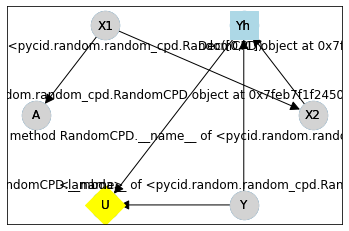

ITV under 0-1 loss possible:  False
ITV under P-adm loss possible:  False
actual ITV under 0-1 loss 0.0
actual ITV under P-adm loss 0.0


In [9]:
cid = random_supervised_learning_cid()
cid.draw()
assess_unfairness(cid)

## Sample CIDs and measure ITV

Now let's sample 20 different CIDs, and count how many have an introduced total effect under 0-1 loss, and under P-admissible loss. Increase the iterations parameter to get more reliable estimates.

In [10]:
samples = 20

theorem9_total = 0
theorem9_results = []

while theorem9_total < samples:
    cid = random_supervised_learning_cid()

    if theorem9_gc(cid):
      theorem9_total += 1
      cid.impute_optimal_policy()
      theorem9_results.append(introduced_total_variation(cid, 'A', 'Yh', 'Y'))
      theorem9_rate = sum(i > 0.01 for i in theorem9_results)/theorem9_total
      print("{:.2f}".format(theorem9_rate) + f" positive under 0-1 loss, count {theorem9_total}")
    else:
      continue  # if the CID doesn't satisfy the graphical condition, we resample

0.00 positive under 0-1 loss, count 1
0.00 positive under 0-1 loss, count 2
0.00 positive under 0-1 loss, count 3
0.00 positive under 0-1 loss, count 4
0.00 positive under 0-1 loss, count 5
0.00 positive under 0-1 loss, count 6
0.14 positive under 0-1 loss, count 7
0.12 positive under 0-1 loss, count 8
0.11 positive under 0-1 loss, count 9
0.10 positive under 0-1 loss, count 10
0.09 positive under 0-1 loss, count 11
0.08 positive under 0-1 loss, count 12
0.08 positive under 0-1 loss, count 13
0.14 positive under 0-1 loss, count 14
0.13 positive under 0-1 loss, count 15
0.12 positive under 0-1 loss, count 16
0.12 positive under 0-1 loss, count 17
0.11 positive under 0-1 loss, count 18
0.11 positive under 0-1 loss, count 19
0.15 positive under 0-1 loss, count 20


In [11]:
samples = 20

theorem11_total = 0
theorem11_results = []

while theorem11_total < samples:
    cid = random_supervised_learning_cid()

    if theorem11_gc(cid):
      theorem11_total += 1
      # impute the policy that'd be optimal under P-admissible loss
      cid.impute_conditional_expectation_decision('Yh', 'Y') 
      theorem11_results.append(introduced_total_variation(cid, 'A', 'Yh', 'Y'))
      theorem11_rate = sum(i > 0.01 for i in theorem11_results)/theorem11_total
      print("{:.2f}".format(theorem11_rate) + f" positive under P-adm loss, count {theorem11_total}")
    else:
      continue  # if the CID doesn't satisfy the graphical condition, we resample

0.00 positive under P-adm loss, count 1
0.00 positive under P-adm loss, count 2
0.33 positive under P-adm loss, count 3
0.25 positive under P-adm loss, count 4
0.20 positive under P-adm loss, count 5
0.17 positive under P-adm loss, count 6
0.14 positive under P-adm loss, count 7
0.12 positive under P-adm loss, count 8
0.11 positive under P-adm loss, count 9
0.10 positive under P-adm loss, count 10
0.09 positive under P-adm loss, count 11
0.08 positive under P-adm loss, count 12
0.08 positive under P-adm loss, count 13
0.07 positive under P-adm loss, count 14
0.07 positive under P-adm loss, count 15
0.06 positive under P-adm loss, count 16
0.06 positive under P-adm loss, count 17
0.06 positive under P-adm loss, count 18
0.05 positive under P-adm loss, count 19
0.05 positive under P-adm loss, count 20
